<h1><b><u>Disaster Tweets Classification </u></b></h1>

<h4 style='text-align: justify;'>
This notebook is mainly to preprocess the dataset. At the beginning, I tested the accuracy that can be reached by using trivial methods to predict the output. Afterwards, the data is procesed to be use by BERT. The machine learning models are notshown in this notebook because I focused on the models on another notebook. Neural networks with BERT was the main interest, yet other algorithm were used too.
<br/>
For the machine learning models, check the link below:
    <a href='https://www.kaggle.com/fmakarem/disaster-tweets-bert'>Machine Learning Notebook</a>
</h4>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/bert-features/BERT_processed.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import OrderedDict,Counter
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import string
import re

In [3]:
n_splits=7
random_state=27

In [4]:
stop=stopwords.words('english')

<h2><b>Functions</b></h2>

<h4>
Here some useful functions are created
</h4>

In [5]:
def get_keyword_mean(train_df,val_df,column='keyword',target='target'):
    aggregate_column=column+'_mean'
    train_df[aggregate_column]=train_df.groupby(column)[target].transform('mean')
    
    val_df = val_df.merge(
                train_df[[column, aggregate_column]].drop_duplicates(),
                on=column,
                how="left",
            )
    return train_df,val_df

In [6]:
def cv_datasets(df,model,regex='^BERT',target_column='target',use_keyword=False,model_function=None,compile_dic={},**kwargs):
    '''
    df: Dataframe to divide the data.
    model: Model used to fit and evaluate the data.
    regex: Regex used to pick a column. By default, it searches for the columns starting with BERT.
    target_column: Name of the column containing the output.
    compile_dic: It is only used for keras models
    '''
    kfold=KFold(n_splits=n_splits,shuffle=True,random_state=random_state)
    results={'Total':0}
    i=0
    
    #iterate through the folds
    for train_index,val_index in kfold.split(df):
        
        if 'keras' in str(type(model)):
            #keras
            model_copy=model_function()
            model_copy.compile(**compile_dic)
    
            model_copy.summary()
        else:
            #sklearn
            model_copy= sklearn.base.clone(model)
            
        train_df=df.iloc[train_index]
        val_df=df.iloc[val_index]
        
        if use_keyword:
            train_df,val_df=get_keyword_mean(train_df,val_df)
            regex+='|^keyword_'
        
        X_train=train_df.filter(regex=regex,axis=1)
        y_train=train_df[target_column]
        
        X_val=val_df.filter(regex=regex,axis=1)
        y_val=val_df[target_column]
        
        #print(X_train)
        X_train=X_train.copy().values
        y_train=y_train.copy().values
        
        X_val=X_val.copy().values
        y_val=y_val.copy().values
        
        'The problem with keras mmodels is the copy itself'
        model_copy.fit(X_train,y_train,**kwargs)
        
        predicted=model_copy.predict(X_val)
        
        metric=confusion_matrix(y_val,predicted)
        
        tn, fp, fn, tp = metric.ravel()
        
        results_matrix=metric
        results['Batch '+str(i)]=results_matrix 
        results['Total']+=np.array(results_matrix)
        i+=1
        
        print(f'{i}th run:\naccuracy: {(tp+tn)/(tn+fp+fn+tp)}\nprecision:{tp/(tp+fp)}\nrecall:{tp/(tp+fn)}\n')
    
    
    tn, fp, fn, tp = results['Total'].ravel()
    
    print(f'Total:\naccuracy: {(tp+tn)/(tn+fp+fn+tp)}\nprecision:{tp/(tp+fp)}\nrecall:{tp/(tp+fn)}\n')
    
    return results
        

In [7]:
def fit_and_predict(model,train_df,test_df,use_keyword=False,regex='^BERT',target_column='target',**kwargs):
    if use_keyword:
        train_df,test_df=get_keyword_mean(train_df,test_df)
        regex+='|^keyword_'

    X_train=train_df.filter(regex=regex,axis=1)
    y_train=train_df[target_column]

    X_test=test_df.filter(regex=regex,axis=1)
    
    model.fit(X_train,y_train,**kwargs)
    
    test_df['predictions']=(model.predict(X_test)>0.5).astype(int)
    
    return test_df

In [8]:
def generate_submission(test_df,predictions_column='predictions',name='submission'):
#     new_submission=pd.DataFrame()
#     new_submission['id']=test_df['id']
#     new_submission['target']=predictions
#     new_submission=new_submission.set_index('id')
    
    new_submission=test_df[['id',predictions_column]].set_index('id').rename(columns={predictions_column:'target'})
    print(f'saving the results in {name}.csv')
    new_submission.to_csv(name+'.csv')
    print('finished saving')
    
    return new_submission

In [9]:
def generate_results(df,model,name='submission',regex='^BERT',target_column='target',use_keyword=False,compile_dic={},model_function=None,**kwargs):
    df['keyword']=df['keyword'].fillna('unk')
    df['location']=df['location'].fillna('unk_location')
    
    train_df=df[df['trainable']==1]
    test_df=df[~(df['trainable']==1)]
    
    results=cv_datasets(train_df,model,regex=regex,target_column=target_column,model_function=model_function,use_keyword=use_keyword,**kwargs)
    
    test_df=fit_and_predict(model,train_df,test_df,use_keyword=use_keyword,regex=regex,target_column=target_column,**kwargs)
    
    test_df['predictions']=test_df['predictions'].values>0.5
    test_df['predictions']=test_df['predictions'].astype(int)
    
    submission=generate_submission(test_df,predictions_column='predictions',name=name)
    
    return results,test_df,submission

In [10]:
df=pd.read_csv('/kaggle/input/bert-features/BERT_processed.csv')
results,test_df,submission=generate_results(df,model=LogisticRegression(solver='sag'),use_keyword=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Thi

1th run:
accuracy: 0.7867647058823529
precision:0.8
recall:0.6821052631578948



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2th run:
accuracy: 0.7628676470588235
precision:0.7596371882086168
recall:0.6878850102669405



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


3th run:
accuracy: 0.8005514705882353
precision:0.7658227848101266
recall:0.7739872068230277



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


4th run:
accuracy: 0.7904411764705882
precision:0.7664399092970522
recall:0.7300215982721382



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


5th run:
accuracy: 0.797608095676173
precision:0.7792494481236203
recall:0.7463002114164905



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


6th run:
accuracy: 0.8022079116835327
precision:0.7442922374429224
recall:0.7599067599067599



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


7th run:
accuracy: 0.7902483900643974
precision:0.7961630695443646
recall:0.6989473684210527

Total:
accuracy: 0.7900958886115854
precision:0.7725643532095146
recall:0.7248547844695812

saving the results in submission.csv
finished saving


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [11]:
df=pd.read_csv('/kaggle/input/bert-features/BERT_processed.csv')

rf_parameters={
    'n_estimators':300,
    'max_depth':20,
    'min_samples_split':80,
    'min_samples_leaf':30,
    'min_weight_fraction_leaf':0.0,
    'max_features':'auto',
    'max_leaf_nodes':40,
    'min_impurity_decrease':0.0,
    'min_impurity_split':None,
}
results,test_df,submission=generate_results(df,model=RandomForestClassifier(**rf_parameters),use_keyword=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1th run:
accuracy: 0.7729779411764706
precision:0.8064516129032258
recall:0.631578947368421



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2th run:
accuracy: 0.7766544117647058
precision:0.8210526315789474
recall:0.6406570841889117



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


3th run:
accuracy: 0.7886029411764706
precision:0.7980049875311721
recall:0.6823027718550106



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


4th run:
accuracy: 0.7803308823529411
precision:0.7947368421052632
recall:0.652267818574514



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


5th run:
accuracy: 0.795768169273229
precision:0.8114143920595533
recall:0.6913319238900634



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


6th run:
accuracy: 0.7930082796688133
precision:0.7741935483870968
recall:0.6713286713286714



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


7th run:
accuracy: 0.7736890524379025
precision:0.8037135278514589
recall:0.6378947368421053

Total:
accuracy: 0.7830027584395114
precision:0.801489757914339
recall:0.6579027820238459



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


saving the results in submission.csv
finished saving


In [12]:
#Best till now
df=pd.read_csv('/kaggle/input/bert-features/BERT_processed.csv')
results,test_df,submission=generate_results(df,model=SVC(C=5),use_keyword=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1th run:
accuracy: 0.7941176470588235
precision:0.8276762402088773
recall:0.6673684210526316



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2th run:
accuracy: 0.7711397058823529
precision:0.7874396135265701
recall:0.6694045174537988



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


3th run:
accuracy: 0.8115808823529411
precision:0.8027522935779816
recall:0.746268656716418



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


4th run:
accuracy: 0.8014705882352942
precision:0.8019559902200489
recall:0.7084233261339092



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


5th run:
accuracy: 0.7994480220791168
precision:0.8
recall:0.718816067653277



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


6th run:
accuracy: 0.796688132474701
precision:0.7574257425742574
recall:0.7132867132867133



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


7th run:
accuracy: 0.7884084636614536
precision:0.811704834605598
recall:0.671578947368421

Total:
accuracy: 0.7946932877971891
precision:0.7981843575418994
recall:0.6988688474472639



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


saving the results in submission.csv
finished saving


In [13]:
df=pd.read_csv('/kaggle/input/bert-features/BERT_processed.csv')
results,test_df,submission=generate_results(df,model=KNeighborsClassifier(200,weights='distance',p=2),use_keyword=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1th run:
accuracy: 0.7362132352941176
precision:0.7568306010928961
recall:0.5831578947368421



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2th run:
accuracy: 0.7352941176470589
precision:0.775623268698061
recall:0.5749486652977412



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


3th run:
accuracy: 0.7518382352941176
precision:0.7506297229219143
recall:0.6353944562899787



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


4th run:
accuracy: 0.7637867647058824
precision:0.7768817204301075
recall:0.6241900647948164



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


5th run:
accuracy: 0.7681692732290708
precision:0.8027397260273973
recall:0.6194503171247357



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


6th run:
accuracy: 0.7608095676172953
precision:0.7393767705382436
recall:0.6083916083916084



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


7th run:
accuracy: 0.7506899724011039
precision:0.7865168539325843
recall:0.5894736842105263

Total:
accuracy: 0.7523972152896361
precision:0.7696498054474709
recall:0.6047080403546317



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


saving the results in submission.csv
finished saving


In [14]:
results,test_df,submission
results['Total']

array([[3750,  592],
       [1293, 1978]])

In [15]:
tn, fp, fn, tp = results['Total'].ravel()
(tn+tp)/(tn+fp+fn+tp)

0.7523972152896361

<h2><b>Get The Data</b></h2>

In [16]:
train_df=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample_submission=pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [17]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [18]:
train_df[train_df['keyword'].notnull()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [19]:
test_df['keyword']=test_df['keyword'].fillna('unk')
test_df

,id,keyword,location,text
0,0,unk,NaN,Just happened a terrible car crash
1,2,unk,NaN,"Heard about #earthquake is different cities, s..."
2,3,unk,NaN,"there is a forest fire at spot pond, geese are..."
3,9,unk,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,unk,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,unk,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,unk,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,unk,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,unk,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [20]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [21]:
pd.isna(train_df).sum()/len(train_df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [22]:
positive_class=train_df['target'].sum()/len(train_df)
print(f'the percentage of ones in the dataset is {np.round(positive_class,2)}')

the percentage of ones in the dataset is 0.43


<h2><b>Simple Methods</b></h2>

<h4 style='text-align: justify;'>
First I did submit the sample results. It achieved a 57% accuracy score. Afterwards, I used generated output files from each of the keyword and location columns. Hence, we can sense what score can be reached using easy methods and whatmore advanced ones can do.
</h4>

In [23]:
keyword_df=pd.DataFrame()
i=0
for keyword,group_df in train_df[['keyword','target']].fillna('unk').groupby('keyword'):
    positive_Kkeyword=group_df['target'].sum()/len(group_df)
    keyword_df.loc[i,['keyword']]=keyword
    keyword_df.loc[i,['count']]=len(group_df)
    keyword_df.loc[i,['% positive']]=positive_Kkeyword
    i+=1
#keyword_df.to_csv('keyword_df.csv')

In [24]:
location_df=pd.DataFrame()
i=0
for keyword,group_df in train_df[['location','target']].fillna('unk').groupby('location'):
    positive_Kkeyword=group_df['target'].sum()/len(group_df)
    location_df.loc[i,['location']]=keyword
    location_df.loc[i,['count']]=len(group_df)
    location_df.loc[i,['% positive']]=positive_Kkeyword
    i+=1
#location_df.to_csv('location_df.csv')

<h4>The idea is to group each row with the same column value (for keyword_df the keyword column while for the location_df the location column). Afterwards, some useful information is added, the most important one (the one that is used in the model) is the % positive which is basically the mean of the target for each group.</h4>

In [25]:
keyword_df.head()

,keyword,count,% positive
0,ablaze,36.0,0.361111
1,accident,35.0,0.685714
2,aftershock,34.0,0.000000
3,airplane%20accident,35.0,0.857143
4,ambulance,38.0,0.526316


In [26]:
print(keyword_df[keyword_df['keyword']==test_df.iloc[0]['keyword']]['% positive'].values[0])
new_submission=pd.DataFrame()
new_submission['id']=test_df['id']
new_submission['target']=test_df.apply(lambda row: int(keyword_df[keyword_df.keyword==row['keyword']]['% positive'].values[0]>=0.5),axis=1)

0.6885245901639344


In [27]:
#new_submission.rename({0:'target'},axis=1)
new_submission.to_csv('to_submit.csv')

In [28]:
new_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


<h4>
The keyword generated output file got 72% score while the location file got a lower score. The location output file generated a lower score than the keyword. This is expected because the location column contains a lot of null values. <br/>
Notice the difference between the sample submission (57%) and the result only using the keyword (72%). This shows the value of the keyword column for this task. It is expected because the keyword is a summary of the tweet using one word.
</h4>

<h2><b>Visualizations</b></h2>

In [29]:
train_ls=list(train_df['text'].str.split(' ').to_numpy())
train_outputs=train_df['target'].values

assert len(train_ls)==len(train_outputs), 'ERROR'

In [30]:
Tokenizer=keras.preprocessing.text.Tokenizer(oov_token=0)
Tokenizer.fit_on_texts(train_ls)

In [31]:
i=0
n_words=len(Tokenizer.word_counts)
for word,count in Counter(Tokenizer.word_counts).most_common():
    print(f'{word}: {count}')
    i+=1
    if count<100:
        break

print(f'{i} word are the most common from {n_words} which is {i/n_words*100}%')

the: 3194
a: 2127
in: 1943
to: 1932
of: 1813
and: 1397
i: 1325
is: 929
for: 880
on: 832
: 770
-: 762
you: 742
my: 667
with: 562
that: 536
at: 531
by: 512
it: 501
this: 460
from: 418
are: 397
be: 396
was: 380
have: 380
like: 340
as: 325
so: 310
just: 309
but: 304
&amp;: 295
up: 292
your: 286
not: 285
me: 270
after: 256
will: 254
has: 247
an: 243
all: 239
out: 238
when: 237
no: 235
i'm: 234
if: 232
get: 225
we: 221
new: 215
via: 214
about: 211
fire: 208
??: 208
more: 200
or: 198
they: 190
been: 190
he: 188
how: 185
what: 180
over: 179
one: 178
now: 176
people: 174
who: 174
it's: 172
into: 171
don't: 166
do: 161
can: 157
...: 145
2: 145
|: 142
emergency: 140
than: 138
there: 135
some: 128
would: 127
his: 127
still: 126
police: 125
disaster: 122
her: 121
body: 118
video: 113
got: 111
burning: 111
why: 109
suicide: 109
had: 108
off: 108
back: 106
were: 106
first: 104
know: 102
see: 100
going: 100
man: 98
97 word are the most common from 28121 which is 0.3449379467302016%


<AxesSubplot:xlabel='target', ylabel='count'>

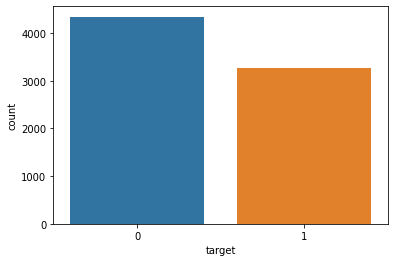

In [32]:
sns.countplot(x='target',data=train_df)

In [33]:
max_characters=np.max(train_df['text'].apply(lambda x: len(x)))
print(f'the max number of characters in a tweet is {max_characters}\nThus, the number of word < {max_characters}')

the max number of characters in a tweet is 157
Thus, the number of word < 157


In [34]:
type(Counter(Tokenizer.word_counts).most_common())

list

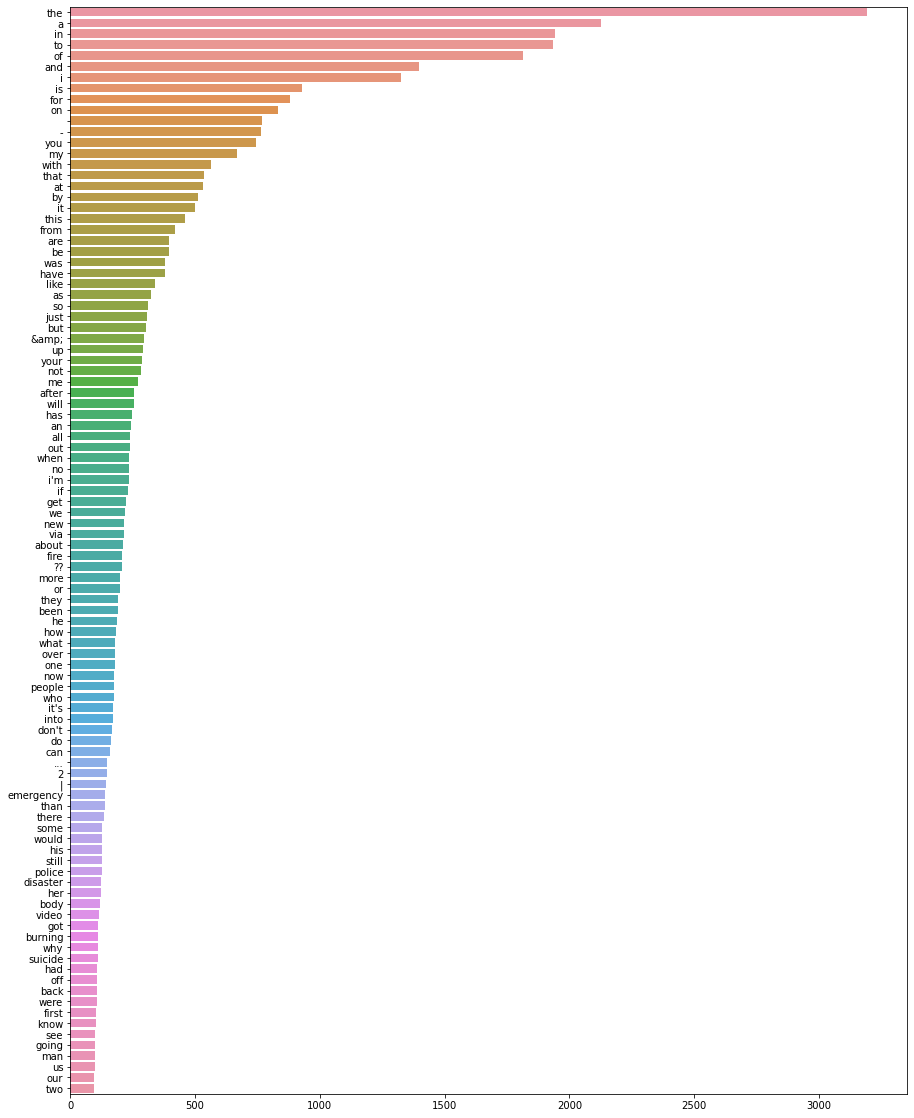

In [35]:
top_100=Counter(Tokenizer.word_counts).most_common()[:100]

x_top_100=[x for x,y in top_100]
y_top_100=[y for x,y in top_100]
ax=sns.barplot(x=y_top_100,y=x_top_100)
ax.figure.set_size_inches(15,20)

<h4 style='text-align: justify;'>
Looking at the top 100 words makes us realized the most used words like 'a' do not give a lot of information if a disaster did occur or not. Actually, only emergency and disaster are word that indicate the possibility of a disaster occuring. Hence, most of the words are stop words that do not give much information about the tweet itself. These words will be removed.
</h4>

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


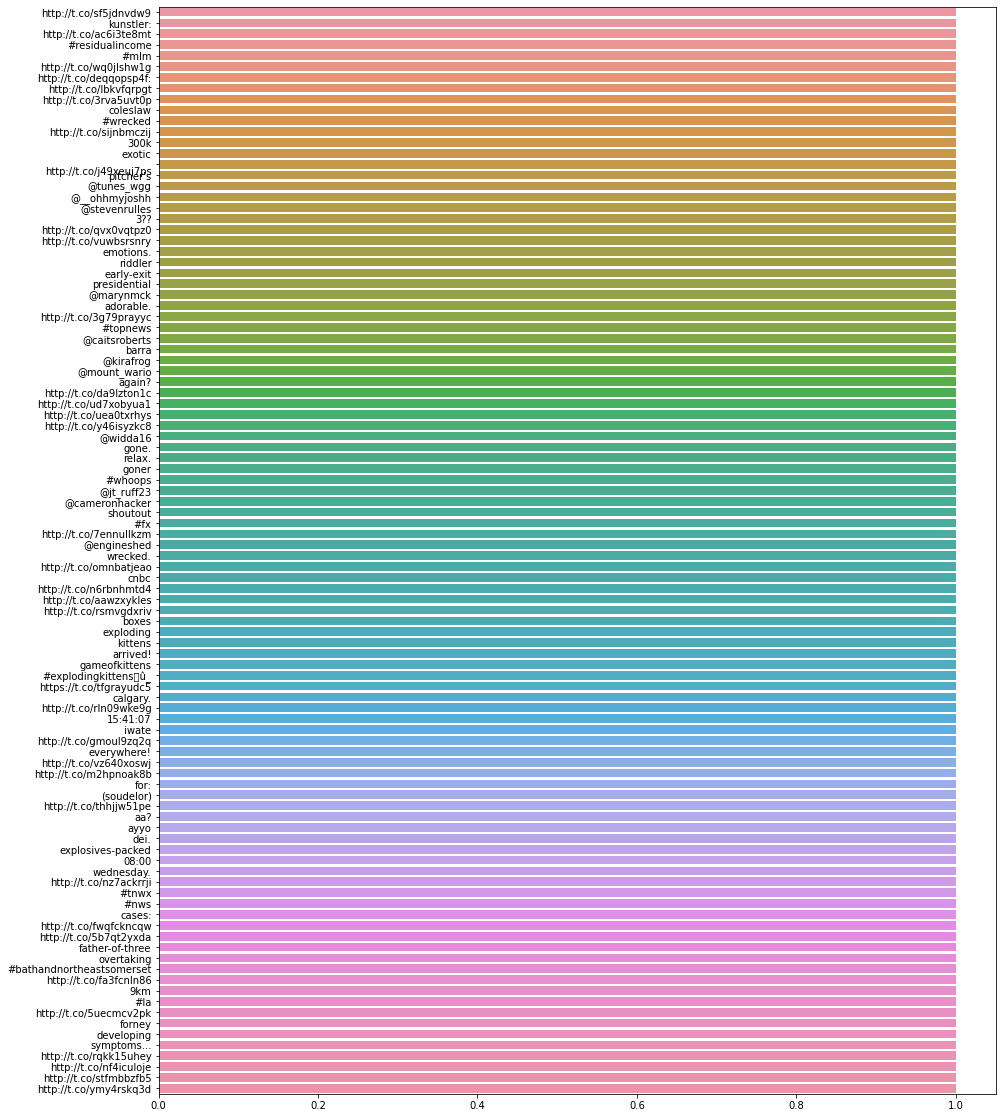

In [36]:
bottom_100=Counter(Tokenizer.word_counts).most_common()[-100:]

x_bottom_100=[x for x,y in bottom_100]
y_bottom_100=[y for x,y in bottom_100]

#Horizontal barplot
ax=sns.barplot(x=y_bottom_100,y=x_bottom_100)
ax.figure.set_size_inches(15,20)

<h4>
The bottom 100 words are all links. I do not think that the presence of a link means a disater happened. I do not expect that a disaster happened if someone tweeted 'check this link http:...'. If there was a link or a radio source that only give information about disasters. Hence, the links will be removed too.
</h4>

<h4>
    <b>Relation beteen words and disaster:</b><br/><br/>
    Now let us see the probability of positive knowing the word. I ill create a dictionary with keys as words and values as a tuple (total_occurances, positive_occurances,disaster_probability).<br/><br/>
    total_occurances: The number of times the word appears.<br/>
    positive_occurances: The number of times the word occurs in a positive sentence.
    <br/>
    <br/>
    Afterwards, we can approximate the probability of disaster knowing word gy dividing positive_occurances by total_occurances. This may look useless, but the model may learn to classify sentences as disasters by just checking the occurance of certain words. That is why it is good to know this metric.
</h4>

In [37]:
word_occurances={}
word_occurances_no_stopwords={}

for i in range(len(train_ls)):
    sentence=train_ls[i]
    output=train_outputs[i]
    
    sentence=list(filter(lambda a: a != '', sentence))
    
    #Get the unique set of words. If a word appeare more than one in a sentence, I do not want to count it
    unique_words=set(sentence)
    
    for word in unique_words:
        word_lower=word.lower()#convert to lower
        #get the values from dictionary of present, else return them as (0,0)
        total_number,positive_number=word_occurances.get(word_lower,(0,0))
        
        #remove non alphanumeric words
        word_lower=re.sub(r'[^a-zA-Z0-9 ]', '', word_lower)
        
        total_number+=1#increment total_number
        # If output is 1, then increment positive_number 
        if output==1:
            positive_number+=1
        
        #update the dictionaries
        word_occurances[word_lower]=(total_number,positive_number)
        if (word_lower not in stop) and ('http' not in word_lower):
            word_occurances_no_stopwords[word_lower]=(total_number,positive_number)

In [38]:
#Generate new dictonaries with key as word and value as the probability
#Let us take the values that occured between 20 and 100.
#If a word appeared just once and it is a disaster, it is difficult to say that the word indictes a disaster.
#Feel free to change the boundaries and test them.
disaster_prob={key:(value[1]/value[0]) for key,value in word_occurances.items() if value[0]>20 and value[0]<100}
disaster_prob_no_stopwords={key:(value[1]/value[0]) for key,value in word_occurances_no_stopwords.items() if value[0]>20 and value[0]<100}

In [39]:
print('length of the dictionary:',len(disaster_prob))
print('words with probability<1:',len([key for key,value in disaster_prob.items() if value !=1]))

length of the dictionary: 194
words with probability<1: 179


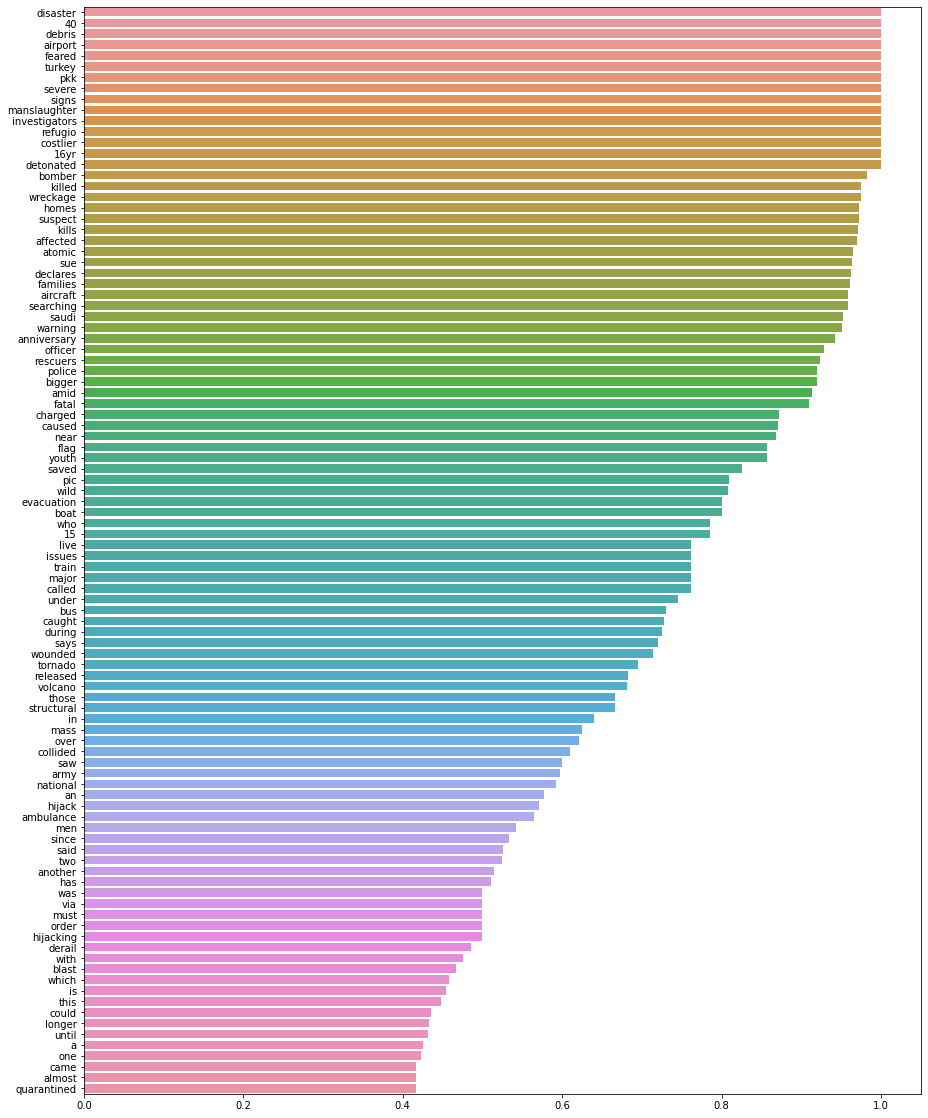

In [40]:
top_100=Counter(disaster_prob).most_common()[:100]

x_top_100,y_top_100=zip(*top_100)
ax=sns.barplot(x=list(y_top_100),y=list(x_top_100))
ax.figure.set_size_inches(15,20)

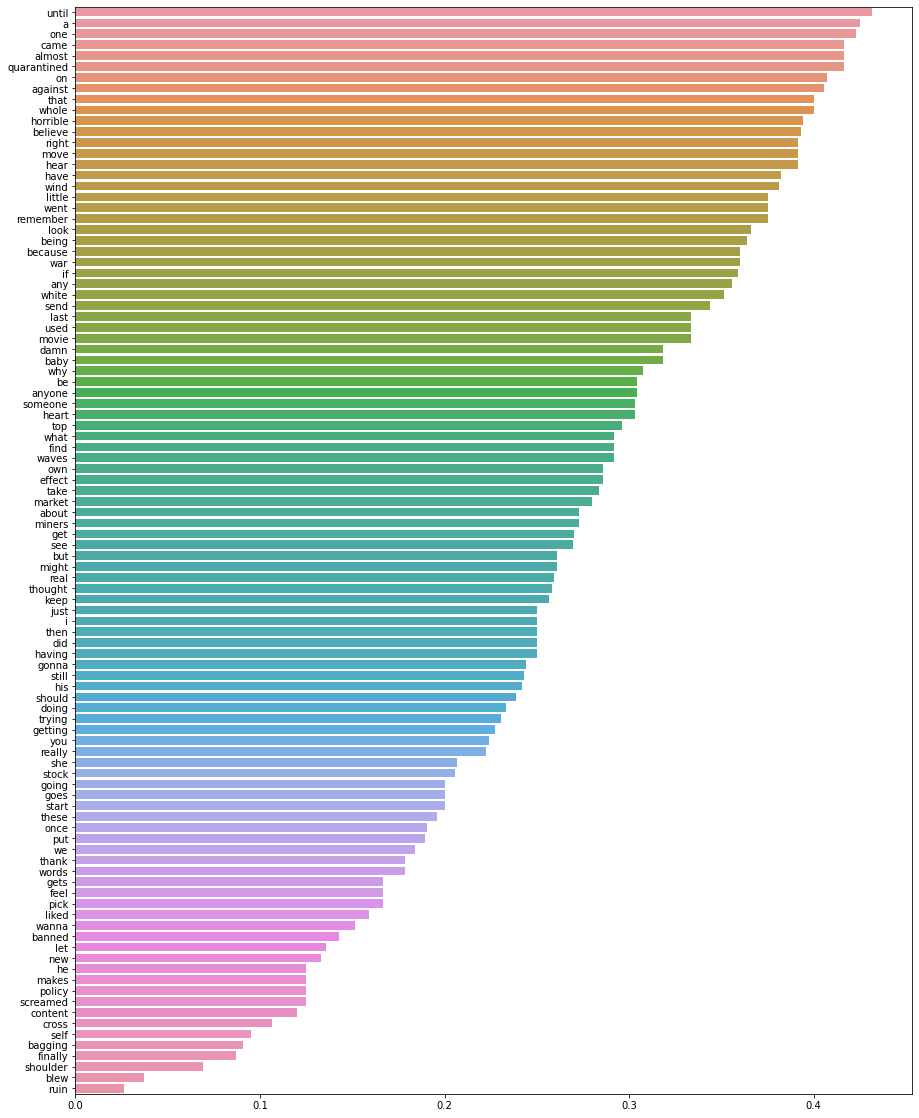

In [41]:
bottom_100=Counter(disaster_prob).most_common()[-100:]

x_bottom_100,y_bottom_100=zip(*bottom_100)
ax=sns.barplot(x=list(y_bottom_100),y=list(x_bottom_100))
ax.figure.set_size_inches(15,20)

In [42]:
print('length of the dictionary',len(disaster_prob_no_stopwords))
print('words with probability<1',len([key for key,value in disaster_prob_no_stopwords.items() if value !=1]))

length of the dictionary 151
words with probability<1 136


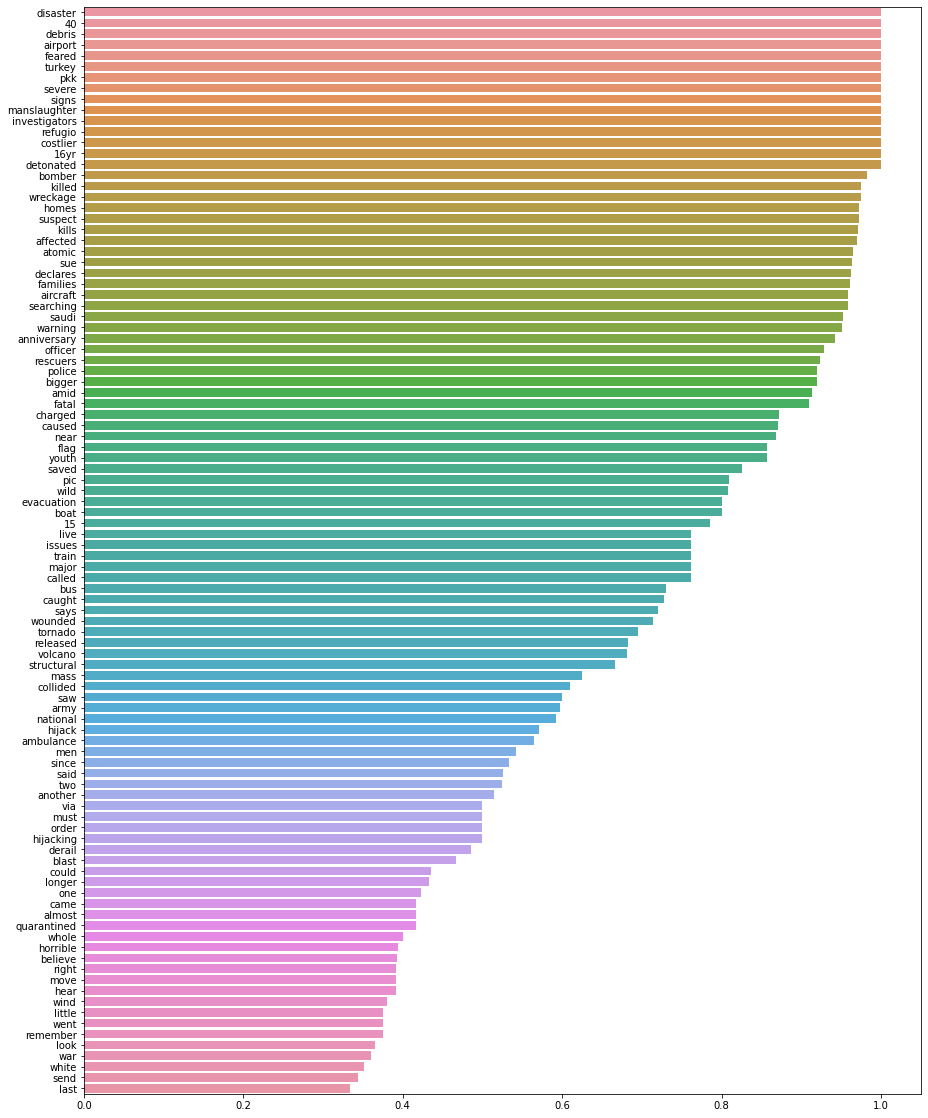

In [43]:
top_100=Counter(disaster_prob_no_stopwords).most_common()[:100]

x_top_100,y_top_100=zip(*top_100)
ax=sns.barplot(x=list(y_top_100),y=list(x_top_100))
ax.figure.set_size_inches(15,20)

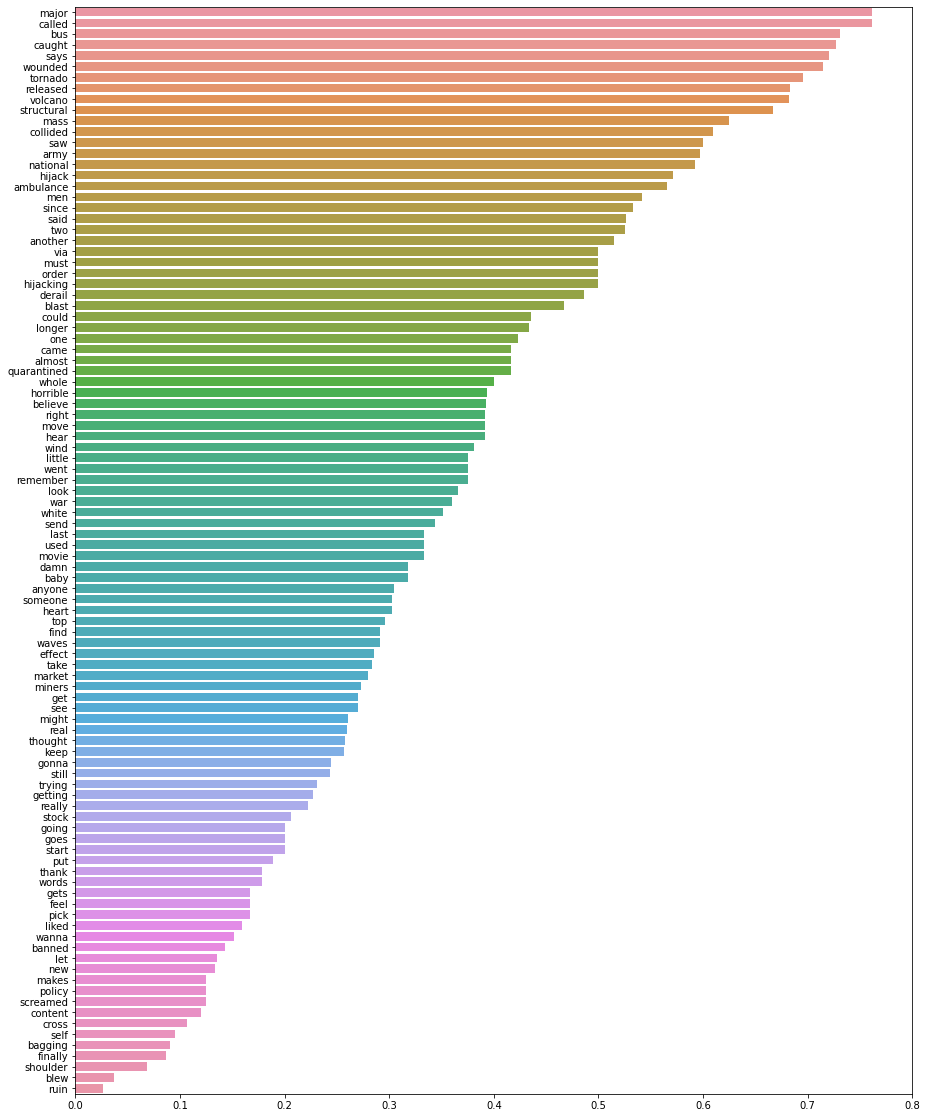

In [44]:
bottom_100=Counter(disaster_prob_no_stopwords).most_common()[-100:]

x_bottom_100,y_bottom_100=zip(*bottom_100)
ax=sns.barplot(x=list(y_bottom_100),y=list(x_bottom_100))
ax.figure.set_size_inches(15,20)

<h2><b>Process Tweets</b></h2>

<h4>
The tweets are processed using the nltk library.
</h4>

In [45]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import string
import re

In [46]:
stop=stopwords.words('english')

# for i in stop:
#     print(i)

In [47]:
total_df=pd.DataFrame()

train_df['trainable']=1
test_df['trainable']=0

total_df=pd.concat((train_df,test_df))
total_df

,id,keyword,location,text,target,trainable
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,1
...,...,...,...,...,...,...
3258,10861,unk,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,0
3259,10865,unk,NaN,Storm in RI worse than last hurricane. My city...,NaN,0
3260,10868,unk,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,0
3261,10874,unk,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,0


In [48]:
train_ls_tmp=[]
stemmer= PorterStemmer()

In [49]:
def get_stem(word:str,stemmer):
    '''
    Get the stem of the word
    '''
    return stemmer.stem(word)

In [50]:
def preprocess_sentence(text,stemmer):
    new_sentence=[]
    
    text = text.replace(r"won't ", "will not ")
    text = text.replace(r"can't ", "can not ")
    text = text.replace(r"ain't ", "am not ")
    
    text = text.replace(r"n't ", " not ")
    text = text.replace(r"'re ", " are ")
    text = text.replace(r"'s ", " is ")
    text = text.replace(r"'d ", " would ")
    text = text.replace(r"'ll ", " will ")
    text = text.replace(r"'t ", " not ")
    text = text.replace(r"'ve ", " have ")
    text = text.replace(r"'m ", " am ")
    
    text = text.translate(str.maketrans('','',string.punctuation))
    
    text=re.sub(r'[^a-zA-Z0-9 ]', '', text)
    #print(text)
    sentence=text.split(' ')
    
    #remove words that are not in english
    sentence=list(filter(lambda a: a != '', sentence))
    
    for word in sentence:
        #word=stemmer.stem(word)
        word_lower=word.lower()
        if (word_lower not in stop) and ('http' not in word_lower):# and ():
            new_sentence.append(word_lower)
    
    return ' '.join(new_sentence)

preprocess_sentence("Hey I'm Yann, ° Ñ  how're you and how's it going ? That's interesting: I'd love to hear more about it. http:idk.com",stemmer)

'hey yann going interesting would love hear'

In [51]:
total_df['preprocessed_text']=total_df['text'].apply(lambda text: preprocess_sentence(text,stemmer))
total_df.head()

,id,keyword,location,text,target,trainable,preprocessed_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,1,got sent photo ruby alaska smoke wildfires pou...


In [52]:
total_df.to_csv('preprocessed_text.csv')

<h1>Conclusion</h1>

<h4 style='text-align: justify;'>
This notebook started by generating outputs using simple methods from the non-tweet features. The keyword output got 72% accuracy. Afterwards, some plots for visualization were shown. The plot showed the effect of stop words and links. Finally, the text was preprocessed to be used with BERT.
</h4>

<h4>
    <b>
        Thank You for reading. I hope it was helpful.
    </b>
</h4>

<h4>
    If you wish to see the prediction part, Checkout my BERT notebook <a href='https://www.kaggle.com/fmakarem/disaster-tweets-bert'>Here</a>
</h4>